In [1]:
import numpy as np
import pandas as pd
import h5py


import pybel
from tfbio.data import Featurizer

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# path to the extracted PDBbind dataset
path = '../PDBBind/2020/

# Parse and clean affinity data

In [ ]:
path1 = "../PDBBind/2020/PDBbind_v2020_other_PL.tar.gz"
path2 = "../PDBBind/2020/PDBbind_v2020_refined.tar.gz"

In [3]:
%%bash -s $path --out missing

path=$1

# Save binding affinities to csv file

echo 'pdbid,-logKd/Ki' > affinity_data.csv
cat $path/PDBbind_2016_plain_text_index/index/INDEX_general_PL_data.2016 | while read l1 l2 l3 l4 l5; do
    if [[ ! $l1 =~ "#" ]]; then
        echo $l1,$l4
    fi
done >> affinity_data.csv


# Find affinities without structural data (i.e. with missing directories)

cut -f 1 -d ',' affinity_data.csv | tail -n +2 | while read l;
    do if [ ! -e $path/general-set-except-refined/$l ] &&  [ ! -e $path/refined-set/$l ]; then
        echo $l;
    fi
done

In [4]:
missing = set(missing.split())
len(missing)

25

In [5]:
affinity_data = pd.read_csv('affinity_data.csv', comment='#')
affinity_data = affinity_data[~np.in1d(affinity_data['pdbid'], list(missing))]
affinity_data.head()

,pdbid,-logKd/Ki
0,3zzf,0.40
1,3gww,0.45
2,1w8l,0.49
3,3fqa,0.49
4,1zsb,0.60


In [6]:
# Check for NaNs

affinity_data['-logKd/Ki'].isnull().any()

False

In [7]:
# Separate core, refined, and general sets

core_set = ! grep -v '#' $path/PDBbind_2016_plain_text_index/index/INDEX_core_data.2016 | cut -f 1 -d ' '
core_set = set(core_set)

refined_set = ! grep -v '#' $path/PDBbind_2016_plain_text_index/index/INDEX_refined_data.2016 | cut -f 1 -d ' '
refined_set = set(refined_set)

general_set = set(affinity_data['pdbid'])


assert core_set & refined_set == core_set
assert refined_set & general_set == refined_set

len(general_set), len(refined_set), len(core_set)

(13283, 4057, 290)

In [8]:
# Exclude v 2013 core set - it will be used as another test set

core2013 = ! cat core_pdbbind2013.ids
core2013 = set(core2013)

affinity_data['include'] = True
affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core2013 & (general_set - core_set))), 'include'] = False

In [9]:
affinity_data.loc[np.in1d(affinity_data['pdbid'], list(general_set)), 'set'] = 'general'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(refined_set)), 'set'] = 'refined'

affinity_data.loc[np.in1d(affinity_data['pdbid'], list(core_set)), 'set'] = 'core'

affinity_data.head()

,pdbid,-logKd/Ki,include,set
0,3zzf,0.40,True,general
1,3gww,0.45,True,general
2,1w8l,0.49,True,general
3,3fqa,0.49,True,general
4,1zsb,0.60,True,general


In [10]:
affinity_data[affinity_data['include']].groupby('set').apply(len).loc[['general', 'refined', 'core']]

set
general    9221
refined    3685
core        290
dtype: int64

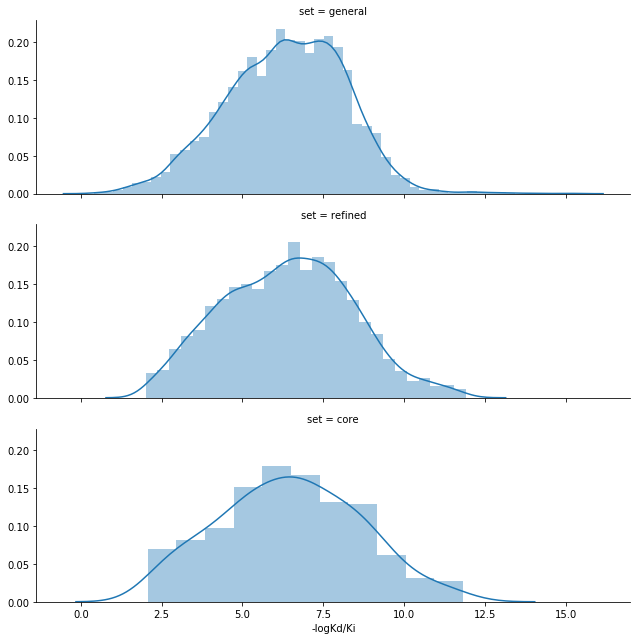

In [11]:
# Check affinity distributions

grid = sns.FacetGrid(affinity_data[affinity_data['include']], row='set', row_order=['general', 'refined', 'core'],
                     size=3, aspect=3)
grid.map(sns.distplot, '-logKd/Ki');

In [12]:
affinity_data[['pdbid']].to_csv('pdb.ids', header=False, index=False)

In [13]:
affinity_data[['pdbid', '-logKd/Ki', 'set']].to_csv('affinity_data_cleaned.csv', index=False)

---

# Parse molecules

In [14]:
dataset_path = {'general': 'general-set-except-refined', 'refined': 'refined-set', 'core': 'refined-set'}

In [15]:
%%bash -s $path

# Prepare pockets with UCSF Chimera - pybel sometimes fails to calculate the charges.
# Even if Chimera fails to calculate several charges (mostly for non-standard residues),
# it returns charges for other residues.

path=$1

for dataset in general-set-except-refined refined-set; do
    echo $dataset
    for pdbfile in $path/$dataset/*/*_pocket.pdb; do
        mol2file=${pdbfile%pdb}mol2
        if [[ ! -e $mol2file ]]; then
            echo -e "open $pdbfile \n addh \n addcharge \n write format mol2 0 tmp.mol2 \n stop" | chimera --nogui
            # Do not use TIP3P atom types, pybel cannot read them
            sed 's/H\.t3p/H    /' tmp.mol2 | sed 's/O\.t3p/O\.3  /' > $mol2file
        fi
    done 
done > chimera_rw.log

In [16]:
featurizer = Featurizer()
charge_idx = featurizer.FEATURE_NAMES.index('partialcharge')

with h5py.File('%s/core2013.hdf' % path, 'w') as g:
    j = 0

    for dataset_name, data in affinity_data.groupby('set'):

        print(dataset_name, 'set')
        i = 0
        ds_path = dataset_path[dataset_name]


        with h5py.File('%s/%s.hdf' % (path, dataset_name), 'w') as f:
            for _, row in data.iterrows():

                name = row['pdbid']
                affinity = row['-logKd/Ki']

                ligand = next(pybel.readfile('mol2', '%s/%s/%s/%s_ligand.mol2' % (path, ds_path, name, name)))
                # do not add the hydrogens! they are in the strucutre and it would reset the charges

                try:
                    pocket = next(pybel.readfile('mol2', '%s/%s/%s/%s_pocket.mol2' % (path, ds_path, name, name)))
                    # do not add the hydrogens! they were already added in chimera and it would reset the charges
                except:
                    warnings.warn('no pocket for %s (%s set)' % (name, dataset_name))
                    continue

                ligand_coords, ligand_features = featurizer.get_features(ligand, molcode=1)
                assert (ligand_features[:, charge_idx] != 0).any()
                pocket_coords, pocket_features = featurizer.get_features(pocket, molcode=-1)
                assert (pocket_features[:, charge_idx] != 0).any() 

                centroid = ligand_coords.mean(axis=0)
                ligand_coords -= centroid
                pocket_coords -= centroid

                data = np.concatenate((np.concatenate((ligand_coords, pocket_coords)),
                                       np.concatenate((ligand_features, pocket_features))), axis=1)

                if row['include']:
                    dataset = f.create_dataset(name, data=data, shape=data.shape, dtype='float32', compression='lzf')
                    dataset.attrs['affinity'] = affinity
                    i += 1
                else:
                    dataset = g.create_dataset(name, data=data, shape=data.shape, dtype='float32', compression='lzf')
                    dataset.attrs['affinity'] = affinity
                    j += 1

        print('prepared', i, 'complexes')
    print('excluded', j, 'complexes')

core set
prepared 290 complexes
general set
prepared 9221 complexes
refined set
prepared 3685 complexes
excluded 87 complexes


In [17]:
with h5py.File('%s/core.hdf' % path, 'r') as f, \
     h5py.File('%s/core2013.hdf' % path, 'r+') as g:
    for name in f:
        if name in core2013:
            dataset = g.create_dataset(name, data=f[name])
            dataset.attrs['affinity'] = f[name].attrs['affinity']

# Protein data

In [18]:
protein_data = pd.read_csv('%s/PDBbind_2016_plain_text_index/index/INDEX_general_PL_name.2016' % path,
                           comment='#', sep='  ', engine='python', na_values='------',
                           header=None, names=['pdbid', 'year', 'uniprotid', 'name'])

protein_data.head()

,pdbid,year,uniprotid,name
0,3eql,2008,Q9Z9H6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
1,1zyr,2005,Q5SHR6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
2,3dxj,2008,Q5SHR6,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
3,4zh4,2015,P0A7Z4,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA
4,4zh3,2015,P0A7Z4,DNA-DIRECTED RNA POLYMERASE SUBUNIT ALPHA


In [19]:
# we assume that PDB IDs are unique
assert ~protein_data['pdbid'].duplicated().any()

protein_data = protein_data[np.in1d(protein_data['pdbid'], affinity_data['pdbid'])]

# check for missing values
protein_data.isnull().any()

pdbid        False
year         False
uniprotid     True
name          True
dtype: bool

In [20]:
protein_data[protein_data['name'].isnull()]

,pdbid,year,uniprotid,name
1158,3t8s,2011,"P29994-2INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR ...",None
5879,3nc9,2010,P50053-2KETOHEXOKINASE,None
5880,3qa2,2012,P50053-2KETOHEXOKINASE,None
5881,3q92,2012,P50053-2KETOHEXOKINASE,None
5882,3qai,2012,P50053-2KETOHEXOKINASE,None
6875,2f4j,2006,P00519 TYROSINE-PROTEIN KINASE ABL1,None


In [21]:
# fix rows with wrong separators between protein ID and name

for idx, row in protein_data[protein_data['name'].isnull()].iterrows():
    uniprotid = row['uniprotid'][:6]
    name = row['uniprotid'][7:]
    protein_data.loc[idx, ['uniprotid', 'name']] = [uniprotid, name]

protein_data.isnull().any()

pdbid        False
year         False
uniprotid     True
name         False
dtype: bool

In [22]:
protein_data.to_csv('protein_data.csv', index=False)